In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split,StratifiedKFold,GridSearchCV,ParameterGrid,cross_val_score,RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,roc_auc_score,roc_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder,MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer

#models
from sklearn.ensemble import RandomForestClassifier,StackingClassifier, GradientBoostingClassifier
from catboost import CatBoostClassifier,Pool
from lightgbm import LGBMClassifier
import xgboost as xgb
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC



In [3]:
#載入資料
train = pd.read_csv(os.path.join('playground-series-s4e10', 'train.csv'),index_col='id')
test_df = pd.read_csv(os.path.join('playground-series-s4e10', 'test.csv'),index_col='id')
origin= pd.read_csv(os.path.join('playground-series-s4e10', 'credit_risk_dataset.csv')) #original dataset

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58645 entries, 0 to 58644
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  58645 non-null  int64  
 1   person_income               58645 non-null  int64  
 2   person_home_ownership       58645 non-null  object 
 3   person_emp_length           58645 non-null  float64
 4   loan_intent                 58645 non-null  object 
 5   loan_grade                  58645 non-null  object 
 6   loan_amnt                   58645 non-null  int64  
 7   loan_int_rate               58645 non-null  float64
 8   loan_percent_income         58645 non-null  float64
 9   cb_person_default_on_file   58645 non-null  object 
 10  cb_person_cred_hist_length  58645 non-null  int64  
 11  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 5.8+ MB


In [5]:
origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [6]:
#合併資料擴充訓練集
train_df=pd.concat([train,origin])
train_df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [7]:
train_df.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
count,91226.000000,9.122600e+04,90331.000000,91226.000000,88110.000000,91226.000000,91226.000000,91226.000000
mean,27.616480,6.477071e+04,4.732119,9350.348607,10.789508,0.163154,5.810219,0.169447
std,6.148115,4.793696e+04,4.025068,5848.605423,3.108998,0.097491,4.038412,0.375149
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,0.000000
25%,23.000000,4.000000e+04,2.000000,5000.000000,7.880000,0.090000,3.000000,0.000000
50%,26.000000,5.700000e+04,4.000000,8000.000000,10.950000,0.140000,4.000000,0.000000
75%,30.000000,7.800000e+04,7.000000,12000.000000,13.110000,0.220000,8.000000,0.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,0.830000,30.000000,1.000000


In [8]:
#移除重複值
print('移除前：',train_df.shape)
train_df.drop_duplicates(inplace=True)
print('移除後：',train_df.shape)

移除前： (91226, 12)
移除後： (91061, 12)


In [9]:
#清理缺失值
train_df.isna().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              887
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3095
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
loan_status                      0
dtype: int64

In [10]:
#用KNN補缺失值

#先把類別變數進行轉換
imputer=KNNImputer(n_neighbors=3)
df_encoded=pd.get_dummies(train_df, columns=['person_home_ownership','loan_intent',], drop_first=False)
df_encoded['loan_grade']=df_encoded['loan_grade'].map({'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6})
df_encoded['cb_person_default_on_file']=df_encoded['cb_person_default_on_file'].map({'Y':1,'N':0})
imputed_data=imputer.fit_transform(df_encoded)

#找到缺失值後再把變數轉換回來
impute=pd.DataFrame(imputed_data, columns=df_encoded.columns)
impute.head()
train_df['person_emp_length']=impute['person_emp_length']
train_df['loan_int_rate']=impute['loan_int_rate']

#清完缺失值
train_df.isna().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
loan_status                   0
dtype: int64

In [11]:
#清除outlier
train_df.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
count,91061.000000,9.106100e+04,91061.000000,91061.000000,91061.000000,91061.000000,91061.000000,91061.000000
mean,27.620683,6.477432e+04,4.691635,9351.508352,10.681401,0.163158,5.812752,0.169546
std,6.150047,4.792286e+04,3.933576,5848.017127,3.033831,0.097486,4.039820,0.375235
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,0.000000
25%,23.000000,4.000000e+04,2.000000,5000.000000,7.880000,0.090000,3.000000,0.000000
50%,26.000000,5.700000e+04,4.000000,8000.000000,10.750000,0.140000,4.000000,0.000000
75%,30.000000,7.800000e+04,7.000000,12000.000000,12.990000,0.220000,8.000000,0.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,0.830000,30.000000,1.000000


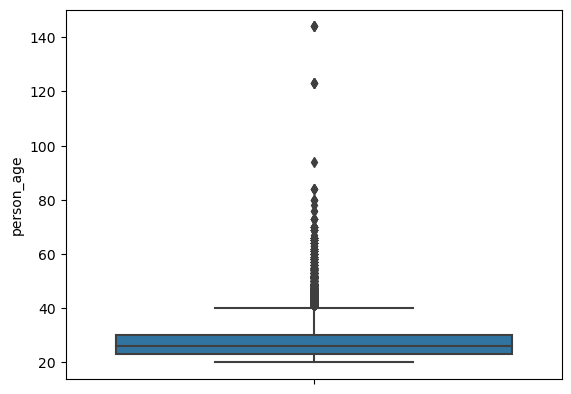

In [12]:
#person_age
sns.boxplot(data=train_df,y='person_age')
plt.show()
train_df[train_df['person_age']>100]
train_df.drop(train_df[train_df['person_age']>100].index,inplace=True)

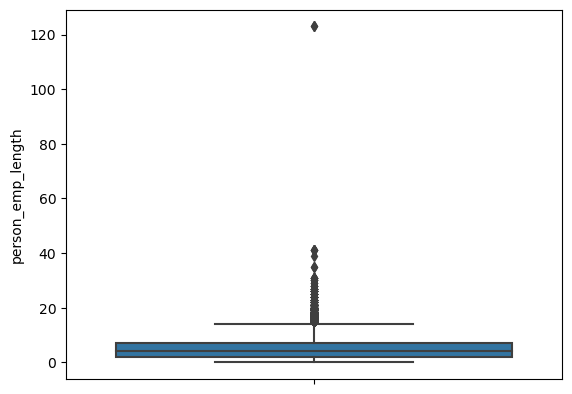

In [13]:
#person_emp_length
sns.boxplot(data=train_df,y='person_emp_length')
plt.show()
train_df[train_df['person_emp_length']>100]
train_df.drop(train_df[train_df['person_emp_length']>100].index,inplace=True)

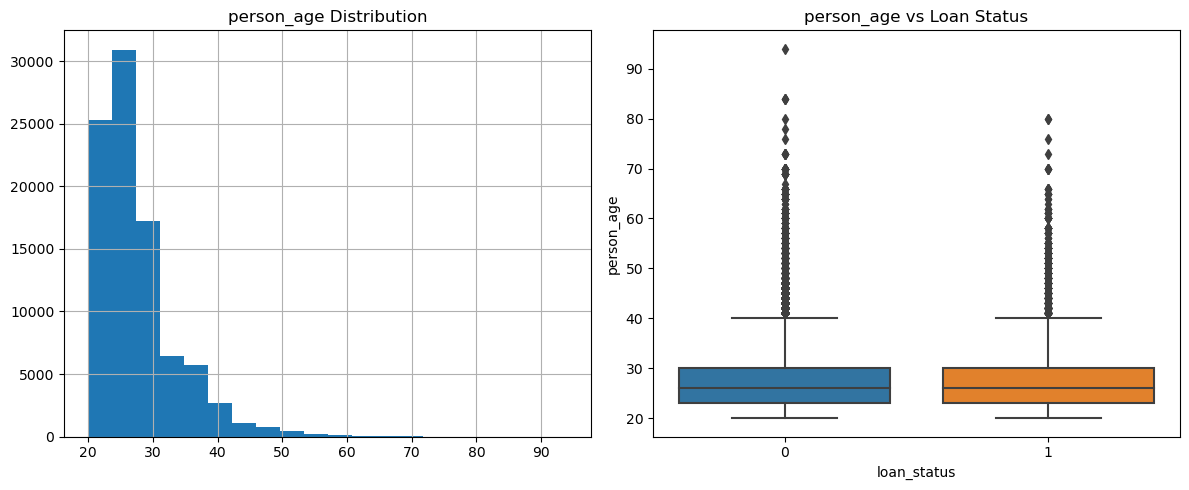

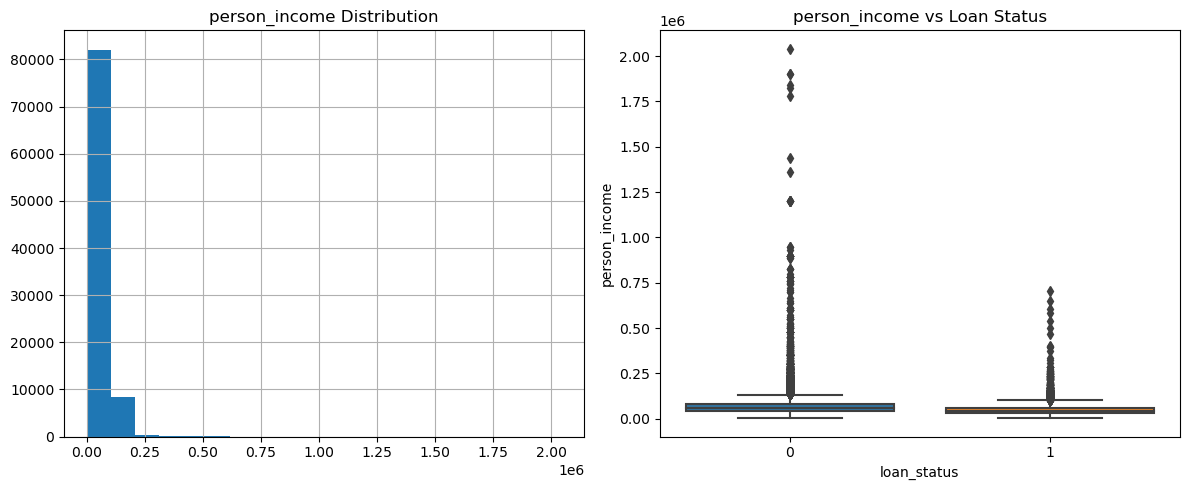

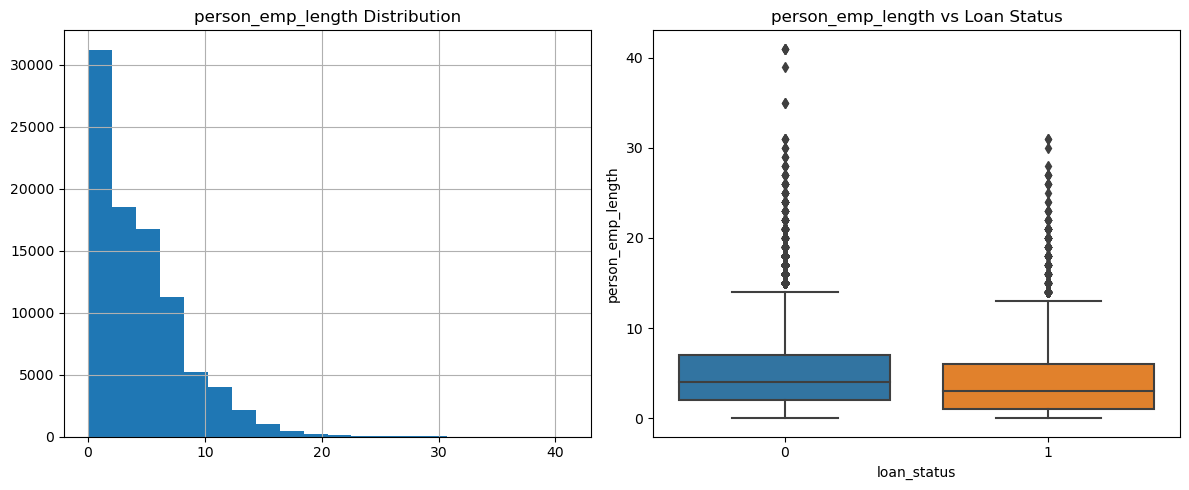

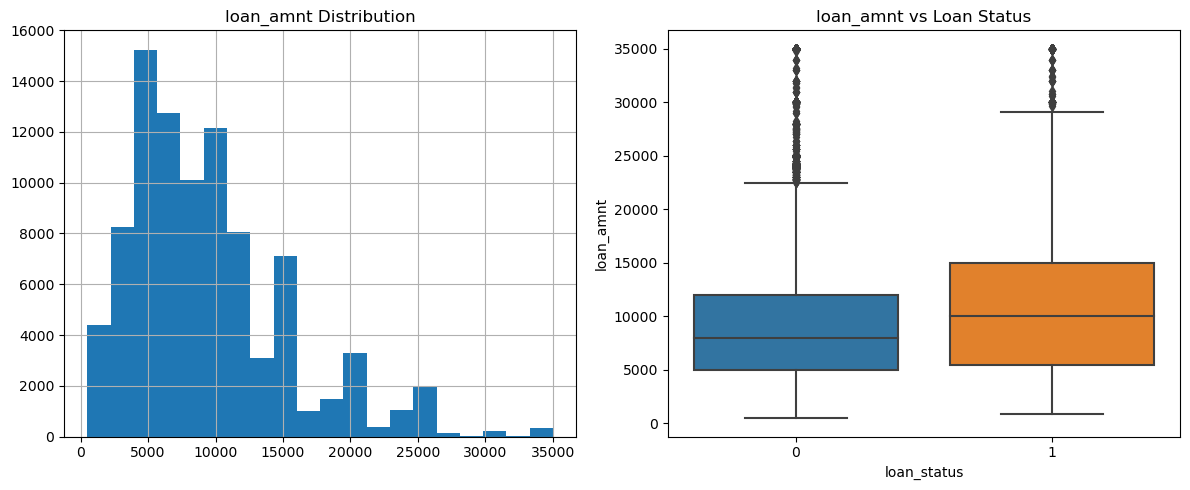

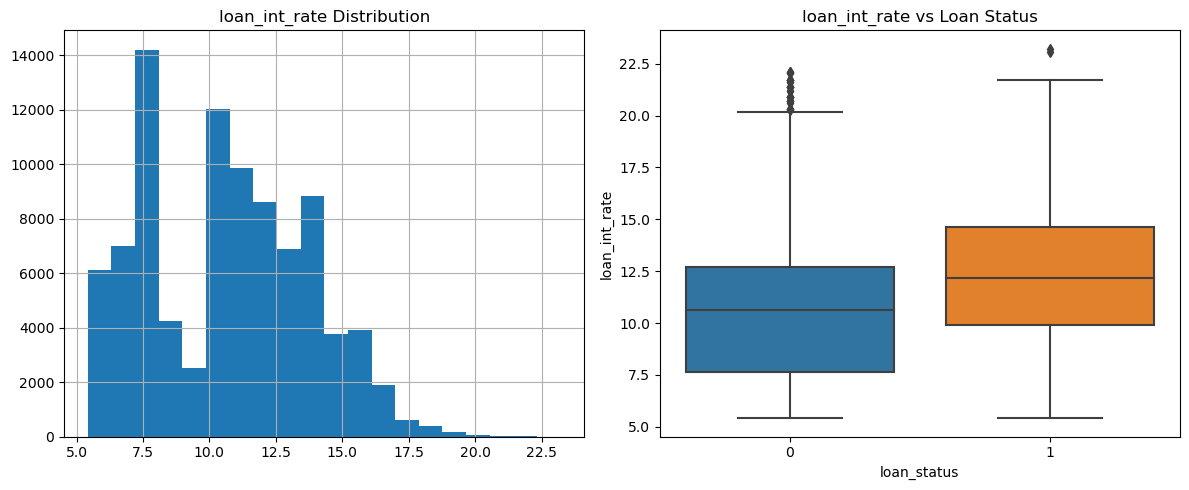

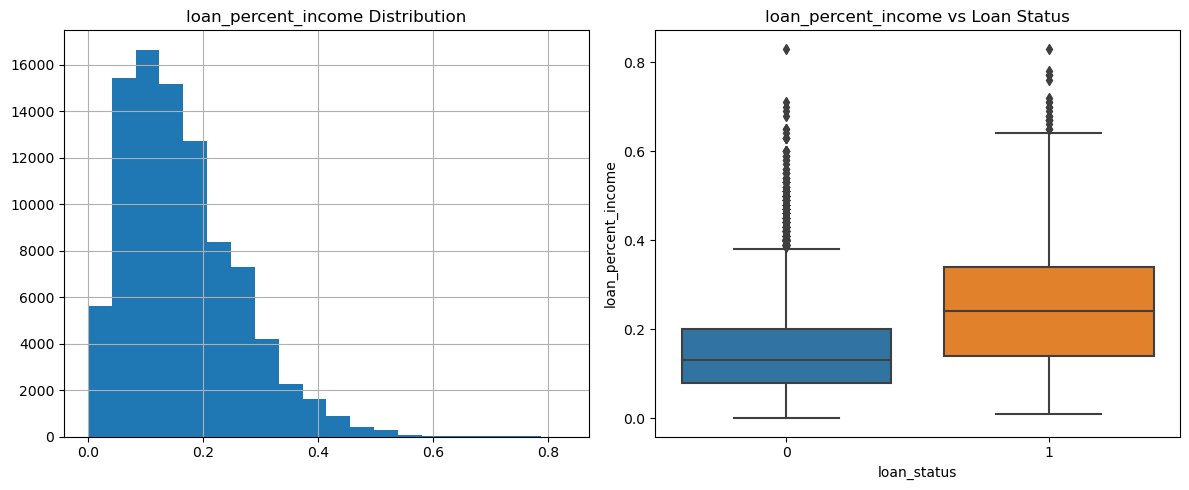

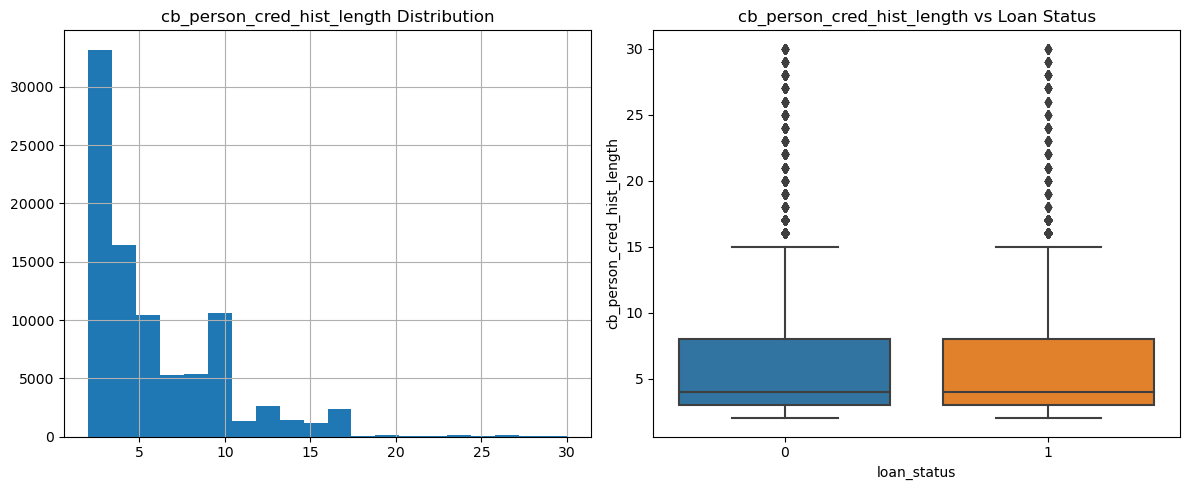

In [14]:
#EDA

#數值特徵
def feature_distribution(df,col):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # hist
    df[col].hist(ax=axes[0],bins=20)
    axes[0].set_title(f'{col} Distribution')

    # boxplot
    sns.boxplot(data=df, x='loan_status', y=col, ax=axes[1])
    axes[1].set_title(f'{col} vs Loan Status')

    plt.tight_layout()
    plt.show()

num_col=['person_age', 'person_income','person_emp_length', 'loan_amnt','loan_int_rate', 'loan_percent_income','cb_person_cred_hist_length']

for cols in num_col:
    feature_distribution(train_df,cols)

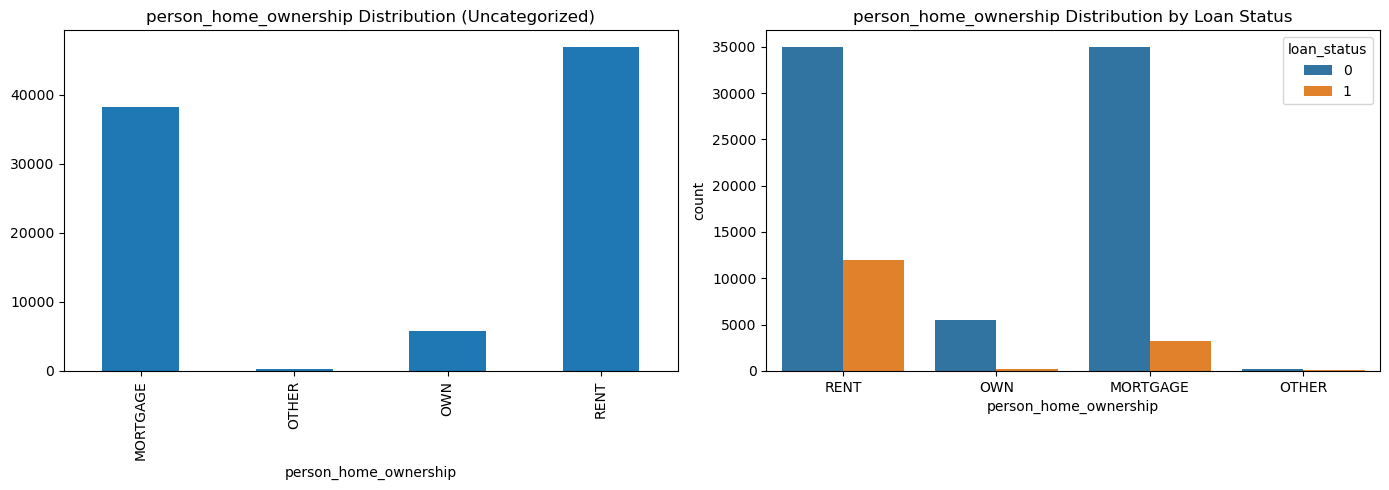

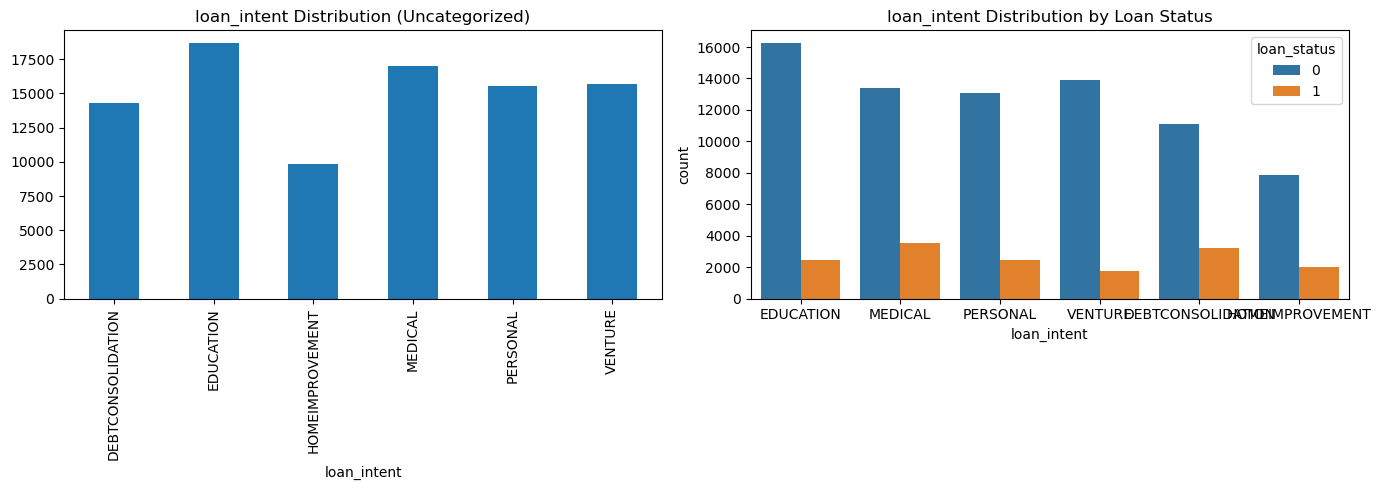

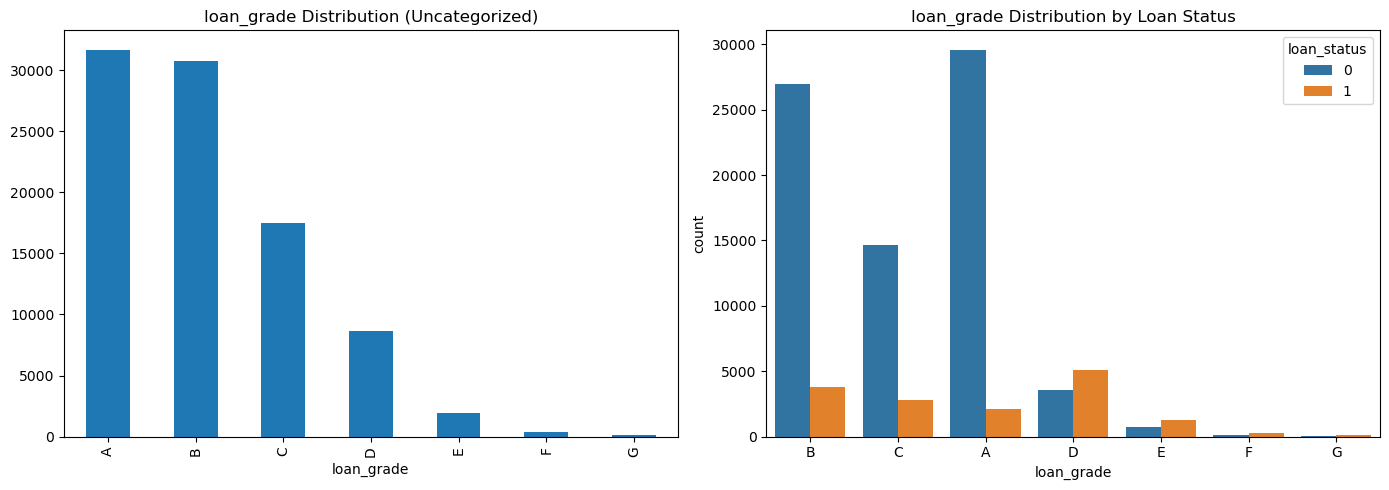

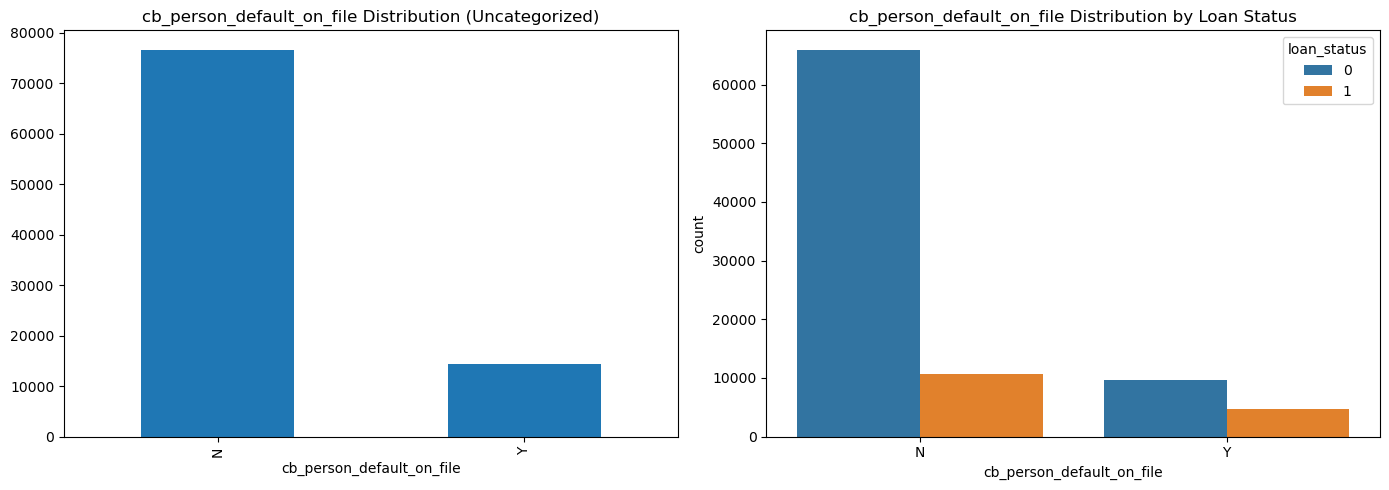

In [15]:
#類別特徵
cat_col=['person_home_ownership','loan_intent','loan_grade','cb_person_default_on_file']
for cols in cat_col:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # 分佈
    train_df[cols].value_counts(
    ).sort_index().plot(kind='bar', ax=axes[0])
    axes[0].set_title(f'{cols} Distribution (Uncategorized)')
    
    # 根據loan_status分組的分佈
    sns.countplot(data=train_df, x=cols, hue='loan_status', ax=axes[1])
    axes[1].set_title(f'{cols} Distribution by Loan Status')
    
    plt.tight_layout()
    plt.show()

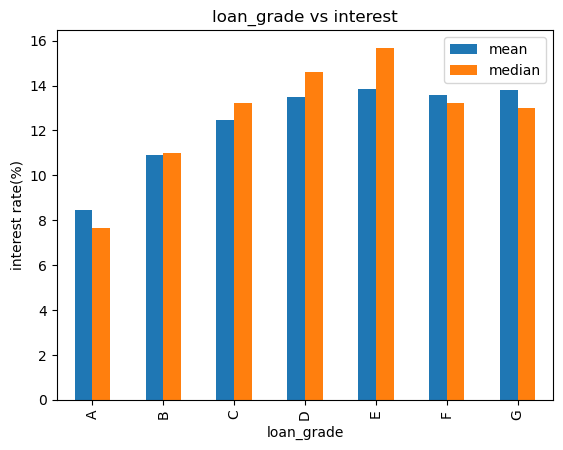

In [16]:
#loan_grade vs interest
train_df.groupby('loan_grade')['loan_int_rate'].agg(['mean','median']).plot(kind='bar')
plt.title('loan_grade vs interest')
plt.ylabel('interest rate(%)')
plt.show()

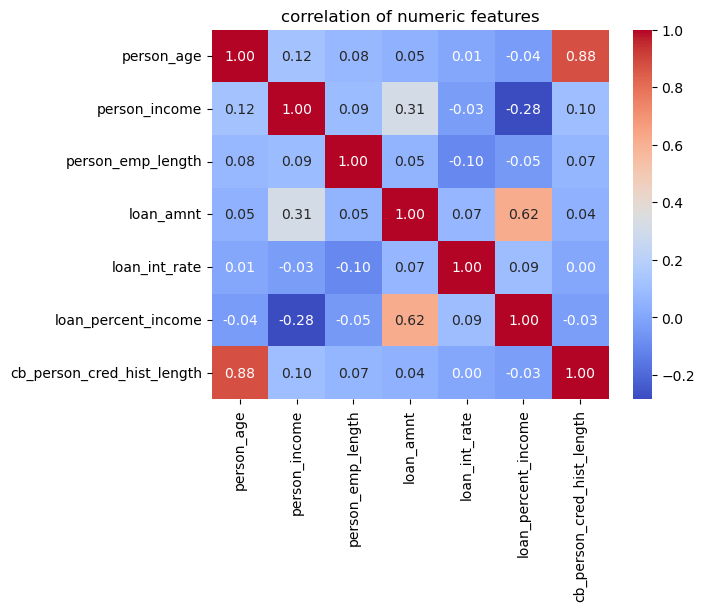

In [17]:
#相關係數
corr=train_df[num_col].corr()
sns.heatmap(corr,fmt='.2f', annot=True, cmap='coolwarm')
plt.title('correlation of numeric features')
plt.show()

In [29]:
#feature engineering
train_df['loan_amnt_percent_adjusted'] = train_df['loan_amnt'] * train_df['loan_percent_income']
test_df['loan_amnt_percent_adjusted'] = test_df['loan_amnt'] * test_df['loan_percent_income']

train_df['income_per_cred_year'] = train_df['person_income'] / train_df['cb_person_cred_hist_length']
test_df['income_per_cred_year'] = test_df['person_income'] / test_df['cb_person_cred_hist_length']

train_df_grade=train_df['loan_grade'].map({'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6})
test_df_grade=test_df['loan_grade'].map({'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6})
train_df['income_adjusted_by_grade'] = train_df['person_income'] / (train_df_grade + 1)
test_df['income_adjusted_by_grade'] = test_df['person_income'] / (test_df_grade + 1)

In [30]:
#preprocessing

#pipeline
cat_col=['person_home_ownership','loan_intent','loan_grade','cb_person_default_on_file']
for col in cat_col:
    train_df[col] = train_df[col].astype('category')
ohe_col=['person_home_ownership','loan_intent','cb_person_default_on_file']
ode_col=['loan_grade']

#one-hot encoding
ohe_pipeline=Pipeline(steps=[
    ('ohe',OneHotEncoder(handle_unknown='ignore',sparse_output=False))
])

#ordinal encoding
ode_pipeline=Pipeline(steps=[
    ('ode',OrdinalEncoder(categories=[['A','B','C','D','E','F','G']],
                         handle_unknown='use_encoded_value',unknown_value=-1))
])

#整合
preprocessor=ColumnTransformer(transformers=[
    ('ohe_p',ohe_pipeline,ohe_col),
     ('ode_p',ode_pipeline,ode_col)
])

In [35]:
#Splt Data
X = train_df.drop(columns=['loan_status'])  # 初始特徵矩陣
y = train_df['loan_status']  # 目標列

#原始
X_train, X_test_, y_train, y_test= train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

#encoding過的
X_encoded=preprocessor.fit_transform(X)
X_encoded_train, X_encoded_test, y_train, y_test= train_test_split(X_encoded, y, test_size=0.2, stratify=y, random_state=42)


In [39]:
#model
#初步比較不同模型後，再選擇模型進行參數調整

# randomforest
rf_clf =RandomForestClassifier(random_state=42)
rf_clf.fit(X_encoded_train, y_train)

y_pred_rf=rf_clf.predict(X_encoded_test)
y_proba_rf = rf_clf.predict_proba(X_encoded_test)[:, 1]
accuracy_rf = accuracy_score(y_test, y_pred_rf)
base_auc_score_rf = roc_auc_score(y_test, y_proba_rf)
print(f"Random Forest ROC AUC Score: {base_auc_score_rf:.6f}")
print(f"Random Forest Accuracy: {accuracy_rf:.6f}")

#Gradient Boosting
gb_clf=GradientBoostingClassifier(random_state=42)
gb_clf.fit(X_encoded_train, y_train)

y_pred_gb=gb_clf.predict(X_encoded_test)
y_proba_gb = gb_clf.predict_proba(X_encoded_test)[:, 1]
accuracy_gb = accuracy_score(y_test, y_pred_gb)
base_auc_score_gb = roc_auc_score(y_test, y_proba_gb)
print(f"Gradient Boosting ROC AUC Score: {base_auc_score_gb:.6f}")
print(f"Gradient Boosting Accuracy: {accuracy_gb:.6f}")

#XGBoost
xgb_clf=xgb.XGBClassifier(random_state=42)
xgb_clf.fit(X_encoded_train, y_train)

y_pred_xgb=xgb_clf.predict(X_encoded_test)
y_proba_xgb = xgb_clf.predict_proba(X_encoded_test)[:, 1]
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
base_auc_score_xgb = roc_auc_score(y_test, y_proba_xgb)
print(f"XGBoost ROC AUC Score: {base_auc_score_xgb:.6f}")
print(f"XGBoost Accuracy: {accuracy_xgb:.6f}")


Random Forest ROC AUC Score: 0.820493
Random Forest Accuracy: 0.880999
Gradient Boosting ROC AUC Score: 0.820351
Gradient Boosting Accuracy: 0.880890
XGBoost ROC AUC Score: 0.821021
XGBoost Accuracy: 0.880835


In [43]:
#Catboost
X_cat = train_df.drop('loan_status', axis=1)
y_cat = train_df['loan_status']
features=X_cat.columns.tolist()
X_cat_string=X_cat.astype('string')

X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(X_cat_string, y_cat, test_size=0.2, random_state=42,stratify=y_cat)

cb_clf=CatBoostClassifier(random_seed=42,verbose=500)
cb_clf.fit(X_train_cat,y_train_cat,eval_set=(X_test_cat,y_test_cat),cat_features=features)
y_pred_cat=cb_clf.predict(X_test_cat)
y_pred_proba_cat=cb_clf.predict_proba(X_test_cat)[:, 1]

#evaluation
roc_auc_cat = roc_auc_score(y_test_cat, y_pred_proba_cat)
accuracy_cat = accuracy_score(y_test_cat, y_pred_cat)
print(f"ROC-AUC Score: {roc_auc_cat:.6f}")
print(f"Accuracy: {accuracy_cat:.6f}")


Learning rate set to 0.091393
0:	learn: 0.5925358	test: 0.5923503	best: 0.5923503 (0)	total: 76.6ms	remaining: 1m 16s
500:	learn: 0.1447259	test: 0.1535170	best: 0.1535167 (499)	total: 49.9s	remaining: 49.7s
999:	learn: 0.1295155	test: 0.1528165	best: 0.1526376 (839)	total: 1m 44s	remaining: 0us

bestTest = 0.1526375523
bestIteration = 839

Shrink model to first 840 iterations.
ROC-AUC Score: 0.964432
Accuracy: 0.946568


In [46]:
#LightGBM
X_lgb = train_df.drop('loan_status', axis=1)
y_lgb = train_df['loan_status']

X_train_lgb, X_test_lgb, y_train_lgb, y_test_lgb = train_test_split(X_lgb, y_lgb, test_size=0.2, random_state=42,stratify=y_cat)

lgb_clf=LGBMClassifier(random_state=42)
lgb_clf.fit(X_train_lgb,y_train_lgb,eval_set=[(X_test_lgb,y_test_lgb)],eval_metric='AUC')

y_pred_lgb=lgb_clf.predict(X_test_lgb)
y_pred_proba_lgb=lgb_clf.predict_proba(X_test_lgb)[:, 1]

#evaluation
roc_auc_lgb = roc_auc_score(y_test_lgb, y_pred_proba_lgb)
accuracy_lgb = accuracy_score(y_test_lgb, y_pred_lgb)
print(f"ROC-AUC Score: {roc_auc_lgb:.6f}")
print(f"Accuracy: {accuracy_lgb:.6f}")

[LightGBM] [Info] Number of positive: 12350, number of negative: 60488
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001600 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1645
[LightGBM] [Info] Number of data points in the train set: 72838, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.169554 -> initscore=-1.588789
[LightGBM] [Info] Start training from score -1.588789
ROC-AUC Score: 0.951778
Accuracy: 0.943602


In [48]:
#svm
num_pipeline=Pipeline(steps=[
    ('scaler',MinMaxScaler())
])
preprocessor_svm=ColumnTransformer(transformers=[
    ('num_p',num_pipeline,num_col),
    ('ohe_p',ohe_pipeline,ohe_col),
     ('ode_p',ode_pipeline,ode_col)
])

X_svm=preprocessor_svm.fit_transform(X)

X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(X_svm, y, test_size=0.2, random_state=42,stratify=y)

svm_clf=SVC(random_state=42,probability=True)
svm_clf.fit(X_train_svm,y_train_svm)
y_pred_svm=svm_clf.predict(X_test_svm)
y_pred_proba_svm=svm_clf.predict_proba(X_test_svm)[:, 1]

#evaluation
roc_auc_svm = roc_auc_score(y_test_svm, y_pred_proba_svm)
accuracy_svm = accuracy_score(y_test_svm, y_pred_svm)
print(f"ROC-AUC Score: {roc_auc_svm:.6f}")
print(f"Accuracy: {accuracy_svm:.6f}")

ROC-AUC Score: 0.882565
Accuracy: 0.920703


In [ ]:
#發現Catboost跟LightGBM表現的比較好
#以表現最好的Catboost進行參數調整、特徵篩選及交叉驗證

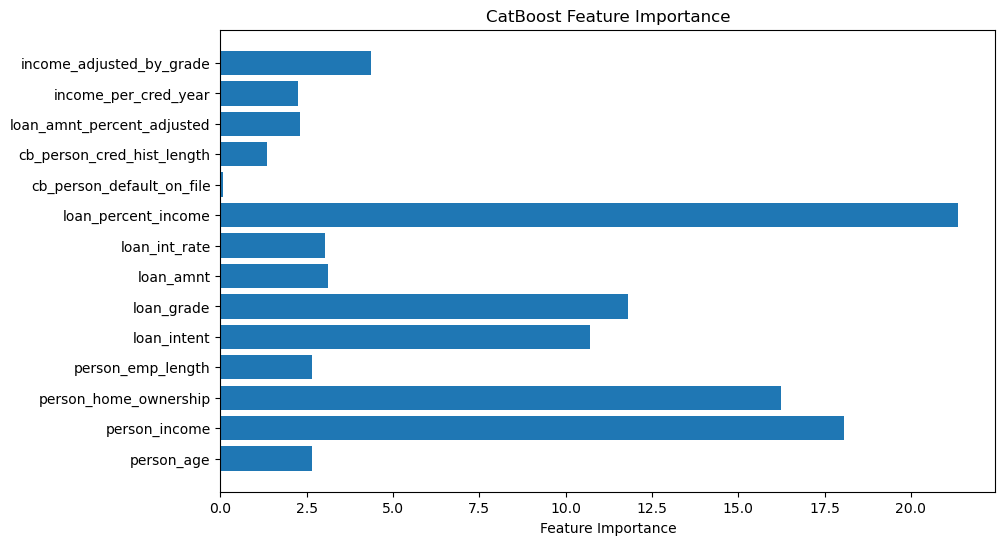

In [49]:
#feature importance
feature_importance = cb_clf.get_feature_importance()
features = X_train.columns

plt.figure(figsize=(10, 6))
plt.barh(features, feature_importance, align='center')
plt.xlabel("Feature Importance")
plt.title("CatBoost Feature Importance")
plt.show()

#刪除cb_person_default_on_file

In [54]:
X_cat = train_df.drop(['loan_status','cb_person_default_on_file'], axis=1)
y_cat = train_df['loan_status']
features=X_cat.columns.tolist()
X_cat_string=X_cat.astype('string')

X_cat_string.info()
features

<class 'pandas.core.frame.DataFrame'>
Index: 91048 entries, 0 to 32580
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   person_age                  91048 non-null  string
 1   person_income               91048 non-null  string
 2   person_home_ownership       91048 non-null  string
 3   person_emp_length           91048 non-null  string
 4   loan_intent                 91048 non-null  string
 5   loan_grade                  91048 non-null  string
 6   loan_amnt                   91048 non-null  string
 7   loan_int_rate               91048 non-null  string
 8   loan_percent_income         91048 non-null  string
 9   cb_person_cred_hist_length  91048 non-null  string
 10  loan_amnt_percent_adjusted  91048 non-null  string
 11  income_per_cred_year        91048 non-null  string
 12  income_adjusted_by_grade    91048 non-null  string
dtypes: string(13)
memory usage: 11.7 MB


['person_age',
 'person_income',
 'person_home_ownership',
 'person_emp_length',
 'loan_intent',
 'loan_grade',
 'loan_amnt',
 'loan_int_rate',
 'loan_percent_income',
 'cb_person_cred_hist_length',
 'loan_amnt_percent_adjusted',
 'income_per_cred_year',
 'income_adjusted_by_grade']

In [60]:
X_cat = train_df.drop(['loan_status','cb_person_default_on_file'], axis=1)
y_cat = train_df['loan_status']
features=X_cat.columns.tolist()
X_cat_string=X_cat.astype('string')

X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(X_cat_string, y_cat, test_size=0.2, random_state=42,stratify=y_cat)


cat_params={'bagging_temperature': 1, 
      'colsample_bylevel': 0.7, 
      'early_stopping_rounds': 300, 
      'eval_metric': 'AUC', 
      'iterations': 5000, 
      'l2_leaf_reg': 2, 
      'learning_rate': 0.02, 
      'loss_function': 'Logloss', 
      'max_depth': 8, 
      'min_data_in_leaf': 15, 
      'random_state': 42, 
      'random_strength': 5, 
      'task_type': 'CPU',
      'verbose':500
     }

cb_clf=CatBoostClassifier(**cat_params)
cb_clf.fit(X_train_cat,y_train_cat,eval_set=(X_test_cat,y_test_cat),verbose=500,plot=True,cat_features=features)
y_pred_cat=cb_clf.predict(X_test_cat)
y_pred_proba_cat=cb_clf.predict_proba(X_test_cat)[:, 1]

#evaluation
roc_auc_cat_adjust = roc_auc_score(y_test_cat, y_pred_proba_cat)
accuracy_cat_adjust = accuracy_score(y_test_cat, y_pred_cat)
print(f"ROC-AUC Score: {roc_auc_cat_adjust:.6f}")
print(f"Accuracy: {accuracy_cat_adjust:.6f}")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.8798596	best: 0.8798596 (0)	total: 110ms	remaining: 9m 9s
500:	test: 0.9597164	best: 0.9597164 (500)	total: 34.8s	remaining: 5m 12s
1000:	test: 0.9631341	best: 0.9631390 (998)	total: 1m 23s	remaining: 5m 32s
1500:	test: 0.9640192	best: 0.9640213 (1496)	total: 2m 30s	remaining: 5m 51s
2000:	test: 0.9645173	best: 0.9645293 (1990)	total: 3m 38s	remaining: 5m 27s
2500:	test: 0.9648808	best: 0.9648808 (2500)	total: 4m 47s	remaining: 4m 47s
3000:	test: 0.9649478	best: 0.9649756 (2868)	total: 6m 3s	remaining: 4m 2s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.9649976552
bestIteration = 3107

Shrink model to first 3108 iterations.
ROC-AUC Score: 0.964998
Accuracy: 0.946787


In [58]:
#cross validation
skfold=StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cb_clf=CatBoostClassifier(**cat_params,cat_features=features)
cross_val_scores = cross_val_score(cb_clf, X_cat_string, y_cat, cv=skfold, scoring='roc_auc')
print("Cross-validation AUC scores:", cross_val_scores)
print("Mean CV AUC:", cross_val_scores.mean())

0:	total: 118ms	remaining: 9m 51s
500:	total: 29.4s	remaining: 4m 24s
1000:	total: 1m 2s	remaining: 4m 8s
1500:	total: 1m 37s	remaining: 3m 47s
2000:	total: 2m 13s	remaining: 3m 20s
2500:	total: 2m 50s	remaining: 2m 50s
3000:	total: 3m 28s	remaining: 2m 18s
3500:	total: 4m 7s	remaining: 1m 45s
4000:	total: 4m 45s	remaining: 1m 11s
4500:	total: 5m 25s	remaining: 36.1s
4999:	total: 6m 4s	remaining: 0us
0:	total: 75.7ms	remaining: 6m 18s
500:	total: 30.8s	remaining: 4m 36s
1000:	total: 1m 7s	remaining: 4m 27s
1500:	total: 1m 44s	remaining: 4m 4s
2000:	total: 2m 22s	remaining: 3m 34s
2500:	total: 3m 1s	remaining: 3m 1s
3000:	total: 3m 40s	remaining: 2m 26s
3500:	total: 4m 21s	remaining: 1m 51s
4000:	total: 5m 4s	remaining: 1m 15s
4500:	total: 5m 48s	remaining: 38.7s
4999:	total: 6m 33s	remaining: 0us
0:	total: 86.3ms	remaining: 7m 11s
500:	total: 39.4s	remaining: 5m 54s
1000:	total: 1m 29s	remaining: 5m 59s
1500:	total: 2m 24s	remaining: 5m 37s
2000:	total: 3m 16s	remaining: 4m 54s
2500:	t

In [61]:
#預測test_df
test_df_cat=test_df.copy()
test_df_cat = test_df_cat.drop(['cb_person_default_on_file'], axis=1)
features=test_df_cat.columns.tolist()
test_df_cat=test_df_cat.astype('string')
y_pred_cat_test=cb_clf.predict(test_df_cat)
y_pred_proba_cat_test=cb_clf.predict_proba(test_df_cat)[:, 1]

In [ ]:
#繳交
submission_cat=pd.DataFrame({'id':test_df.index,'loan_status':y_pred_proba_cat_test})
submission_cat.to_csv('submission_cat.csv', index=False)